In [ ]:
pip install -r requirements.txt

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.compose import make_column_transformer

########### mflow ############
import mlflow
import mlflow.sklearn
########### mflow ############

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sharelib import *
import logging
from pathlib import Path
import json
import glob
import sys
import pickle

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

jenkinsURL = getArgs(1,"")
mlflowMinioFolder = getArgs(2,"")
mlflowTrainingFileLimit = int(getArgs(13,999))

# print(mlflowTrainingFileLimit)

In [2]:
if __name__ == "__main__":
    df = pd.DataFrame()
    path_to_json = 'rawdata' 
    json_pattern = os.path.join(path_to_json,'*.txt')
    file_list = glob.glob(json_pattern)
    
    xcount = 0

    for file in file_list:
        xcount = xcount + 1
        print("xcount: ", xcount)
        data = pd.read_json(file, lines=True)
        df = pd.concat([df,data], ignore_index = True)
        if (xcount == mlflowTrainingFileLimit):
            break

xcount:  1
xcount:  2
xcount:  3
xcount:  4
xcount:  5
xcount:  6
xcount:  7
xcount:  8
xcount:  9
xcount:  10
xcount:  11
xcount:  12
xcount:  13
xcount:  14
xcount:  15
xcount:  16
xcount:  17
xcount:  18
xcount:  19
xcount:  20
xcount:  21
xcount:  22
xcount:  23
xcount:  24
xcount:  25
xcount:  26
xcount:  27
xcount:  28
xcount:  29
xcount:  30
xcount:  31
xcount:  32
xcount:  33
xcount:  34
xcount:  35
xcount:  36
xcount:  37
xcount:  38
xcount:  39
xcount:  40
xcount:  41
xcount:  42
xcount:  43
xcount:  44
xcount:  45
xcount:  46
xcount:  47
xcount:  48
xcount:  49
xcount:  50
xcount:  51
xcount:  52
xcount:  53
xcount:  54
xcount:  55
xcount:  56
xcount:  57
xcount:  58
xcount:  59
xcount:  60
xcount:  61
xcount:  62
xcount:  63
xcount:  64
xcount:  65
xcount:  66
xcount:  67
xcount:  68
xcount:  69
xcount:  70
xcount:  71
xcount:  72
xcount:  73
xcount:  74
xcount:  75
xcount:  76
xcount:  77
xcount:  78
xcount:  79
xcount:  80
xcount:  81
xcount:  82
xcount:  83
xcount:  84
x

In [3]:
    np.set_printoptions(threshold=sys.maxsize)
    
    df_categories = df[df["ads_country_dst"].str.startswith(('1', '2', '3', '4', '5', '6', '7', '8', '9', '0')) == False] 
    df_categories = pd.concat([df_categories["ads_country_dst"]], axis=1, sort=False,)
    print("-------------- Count Record --------------")
    print(df_categories.shape[0])
    print("-------------- Count Record --------------")
    print("-------------- Count Destination Country --------------")
    print(df_categories.value_counts().to_string())
    print("-------------- Count Destination Country --------------")

    countryStr = listOfCountryDst()
    print("-------------- Number of Country in Encoding --------------")
    print(len(countryStr))
    print("-------------- Number of Country in Encoding --------------")    
    print("-------------- Show Country Not in list --------------")
    print(df_categories[~df_categories['ads_country_dst'].isin(countryStr)].value_counts().to_string())
    print("-------------- Show Country Not in list --------------")

    df_categories = df_categories.mask(~df_categories.isin(countryStr),'OTHER')
    X_transform = createXTransformOrdinalDst()
    # print(X_transform.categories_)
    # print(X_transform.inverse_transform([[ 0 ]]))
    X = X_transform.transform(df_categories)
    # print("-------------- Sample Row -------------")
    # print(X.shape[0])
    # print("-------------- Sample Row -------------")

    # print("--------------Count Destination Country-With OrdinalEncoder-------------")
    # print(X.value_counts().to_string())
    # print("--------------Count Destination Country-With OrdinalEncoder-------------")

-------------- Count Record --------------
2383831
-------------- Count Record --------------
-------------- Count Destination Country --------------
ads_country_dst                          
United States                                1037273
Austria                                       455112
Thailand                                      416445
Brazil                                        117551
China                                          59613
Netherlands                                    44002
Singapore                                      40493
Japan                                          40195
Sweden                                         27489
United Kingdom                                 23250
Australia                                      18246
Asia Pacific Region                            16551
Russian Federation                             12314
Malaysia                                        8789
Korea Republic Of                               8705
Hong Kong    

In [20]:
# Call and fit the Local Outlier Factor detector
lof_detector = LocalOutlierFactor(n_neighbors=10, contamination=0.01,novelty=True).fit(X.values)

print("-------------- Model Size (MB) --------------")
print("{:.2f}".format(sys.getsizeof(pickle.dumps(lof_detector))/(1024*1024)))
print("-------------- Model Size (MB) --------------")

lof_detect = lof_detector.predict(X)

-------------- Model Size (MB) --------------
5.42
-------------- Model Size (MB) --------------


In [7]:
recordDetect,countDetect = np.unique(lof_detect, return_counts=True)
print("--------------Count Anomaly VS Normal-------------")
print("Anomaly = " , countDetect[0] , "record with " , (countDetect[0])*100/(countDetect[0]+countDetect[1]) ," %")
print("Normal  = " , countDetect[1] , "record with " , (countDetect[1])*100/(countDetect[0]+countDetect[1]) ," %")
print("--------------Count Anomaly VS Normal-------------")
# print(lof_detect)

--------------Count Anomaly VS Normal-------------
Anomaly =  142 record with  0.2850833166030918  %
Normal  =  49668 record with  99.71491668339691  %
--------------Count Anomaly VS Normal-------------


In [9]:
print("-------------- List Destination Country with Prediction -------------")
# print(type(df_categories.value_counts()))
# print(type(df_categories))
for index, value in df_categories.value_counts().items():
    tempdf = pd.DataFrame([
        [index[0]]
    ], columns=['ads_country_dst'])
    encode = X_transform.transform(tempdf)
    predictData = lof_detector.predict(encode)
    print(index[0]  , " | code =" , encode.values[0][0] , " | count ="  , value , " | result =" , dataPredictionToString(predictData[0]))

print("-------------- List Destination Country with Prediction -------------")

-------------- List Destination Country with Prediction -------------
United States  | code = 170.0  | count = 22157  | result = Normal
Austria  | code = 15.0  | count = 9048  | result = Normal
Thailand  | code = 159.0  | count = 6565  | result = Normal
Brazil  | code = 28.0  | count = 2436  | result = Normal
China  | code = 38.0  | count = 2154  | result = Normal
Netherlands  | code = 115.0  | count = 1566  | result = Normal
Sweden  | code = 153.0  | count = 706  | result = Normal
Japan  | code = 83.0  | count = 692  | result = Normal
Australia  | code = 14.0  | count = 651  | result = Normal
Singapore  | code = 144.0  | count = 563  | result = Normal
Russian Federation  | code = 137.0  | count = 520  | result = Normal
United Kingdom  | code = 169.0  | count = 403  | result = Normal
Canada  | code = 36.0  | count = 397  | result = Normal
Asia Pacific Region  | code = 13.0  | count = 209  | result = Normal
Korea Republic Of  | code = 88.0  | count = 183  | result = Normal
Hong Kong  | 

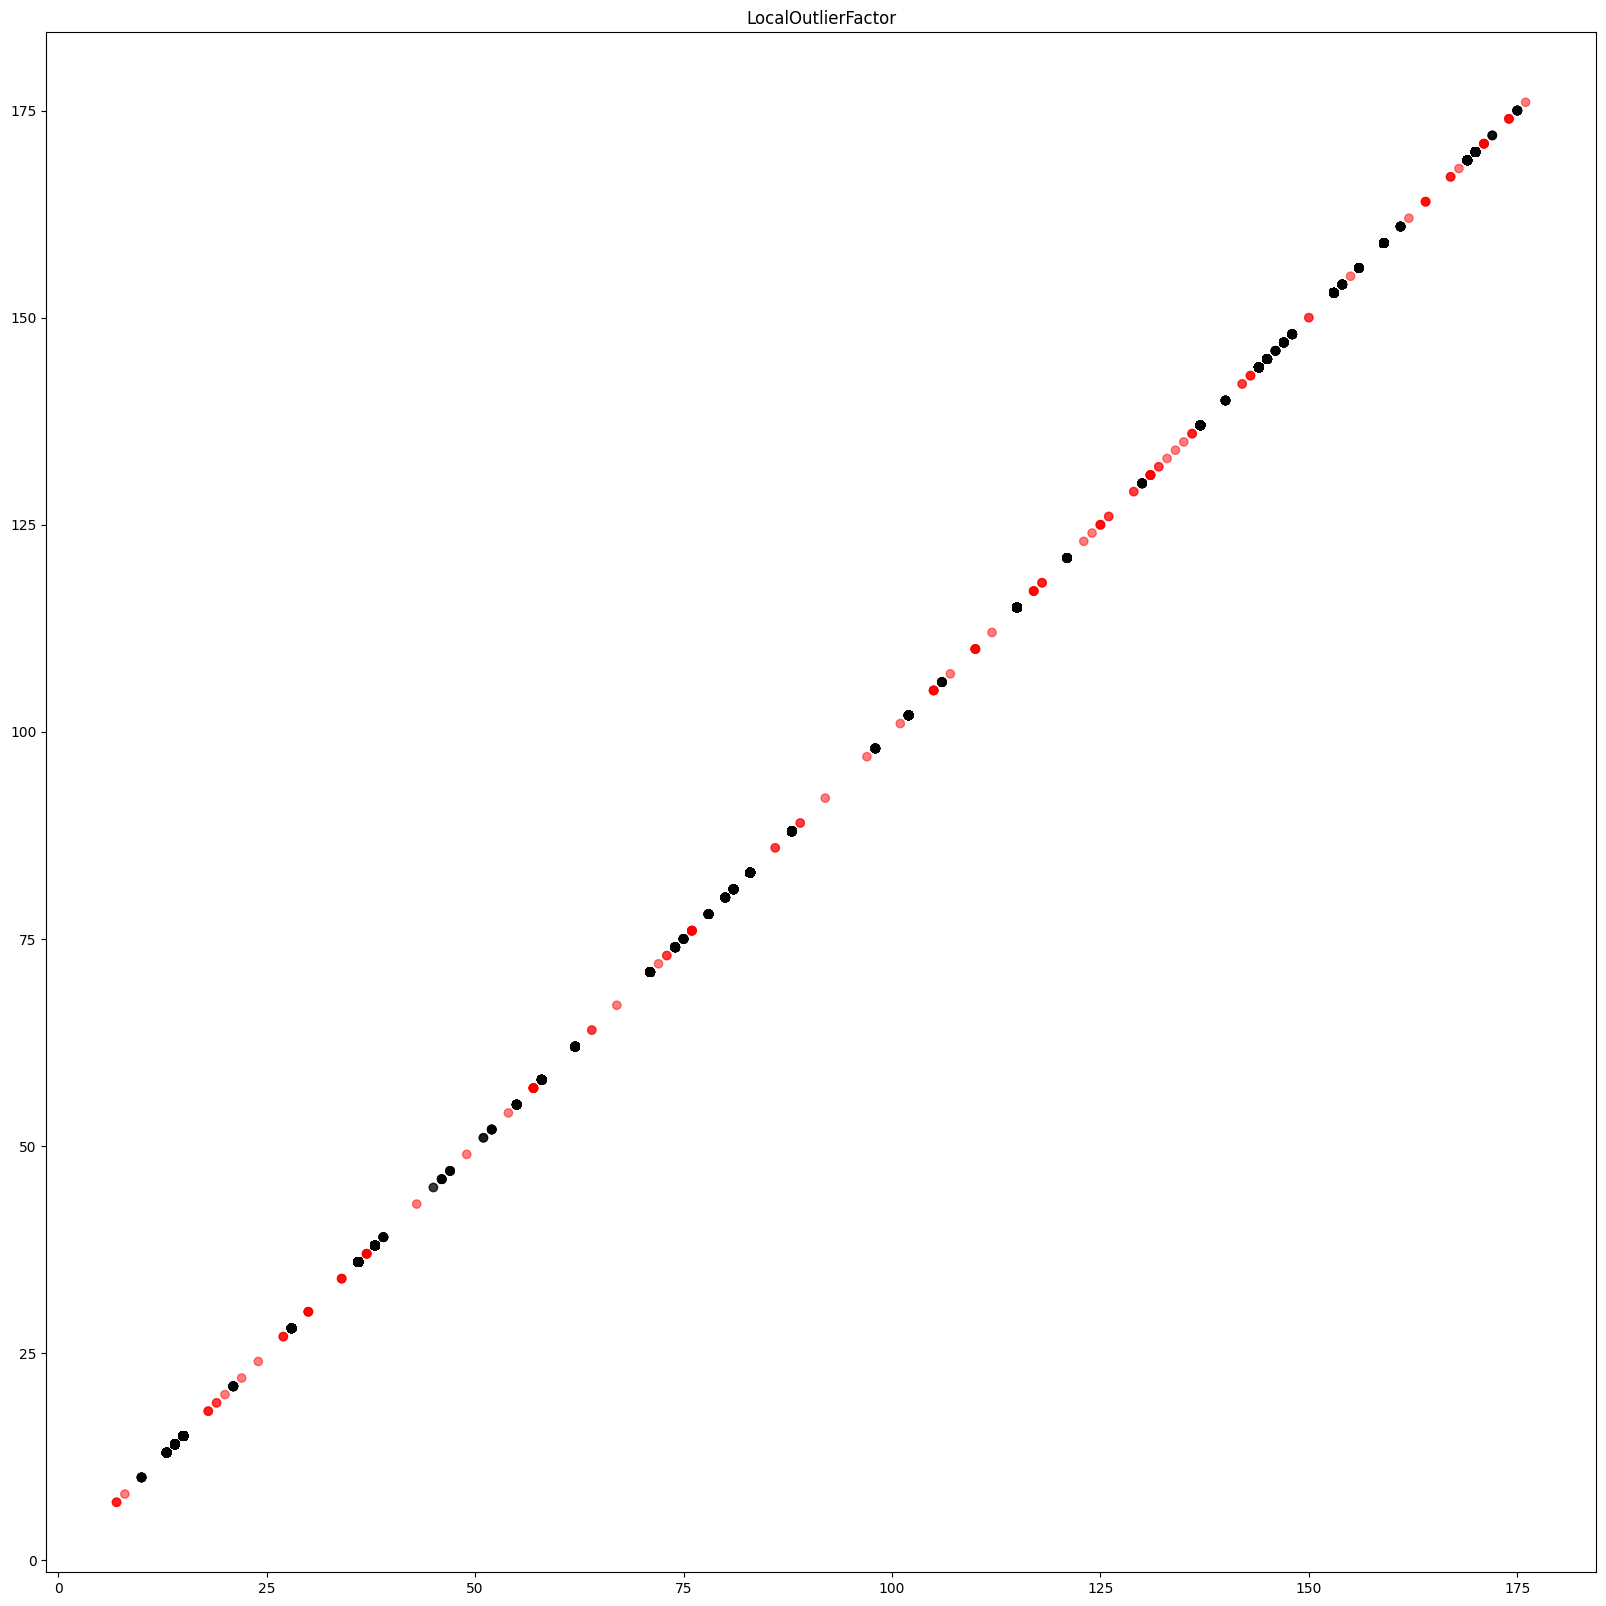

In [10]:
plt.figure(figsize=(20,20))
plt.scatter(X.to_numpy()[:, 0], X.to_numpy()[:, 0], c=lof_detect, cmap="flag", alpha=0.5)
plt.title("LocalOutlierFactor")
plt.show()

In [8]:
# print(X[35:36 :])
# print(lof_detector.predict(X[35:36 :]))
# print(lof_detector.predict([[ 158 ]]))
# print(lof_detector.predict(X))



In [11]:
%set_env MLFLOW_TRACKING_URI=http://127.0.0.1:5000
# %set_env MLFLOW_TRACKING_URI=http://mlflow.rtarf-ml.its-software-services.com/
tracking_uri = os.environ["MLFLOW_TRACKING_URI"]
# export MLFLOW_TRACKING_USERNAME=user 
# export MLFLOW_TRACKING_PASSWORD=pwd

experiment = mlflow.set_experiment(experiment_name='ads-anomaly-dest-country')
experiment_id = experiment.experiment_id

run_description = f"""
### Note
**All information** * about Training * ~~ML here~~ .
Jenkins URL: [{jenkinsURL}]({jenkinsURL})
"""

with mlflow.start_run(experiment_id=experiment_id,description=run_description):
    mlflow.set_tracking_uri(tracking_uri)
    
    print("Artifact Location: {}".format(experiment.artifact_location))
    print("artifact uri : " + mlflow.get_artifact_uri())

    mlflow.doctor()
    mlflow.log_param("MlflowMinioFolder", mlflowMinioFolder)
    mlflow.log_param("CountryEncodingAmount", len(countryStr))
    mlflow.log_param("SampleFile", xcount)
    mlflow.log_param("SampleRows", X.shape[0])
    # mlflow.set_tag("JenkinsURL",jenkinsURL)

    mlflow.log_metric("Anomaly", str((countDetect[0])*100/(countDetect[0]+countDetect[1])))
    mlflow.log_metric("Normal", str((countDetect[1])*100/(countDetect[0]+countDetect[1])))
    mlflow.sklearn.log_model(lof_detector, "model", registered_model_name="ads-anomaly-by-dest-country")
    print("Model saved in run %s" % mlflow.active_run().info.run_uuid)

env: MLFLOW_TRACKING_URI=http://127.0.0.1:5000
Artifact Location: mlflow-artifacts:/245826297813236868
artifact uri : mlflow-artifacts:/245826297813236868/98c5f11e50c64cadb0b85019c44f9c66/artifacts
System information: Windows 10.0.19045
Python version: 3.9.7
MLflow version: 2.1.1
MLflow module location: C:\Users\sutee.k\AppData\Roaming\Python\Python39\site-packages\mlflow\__init__.py
Tracking URI: http://127.0.0.1:5000
Registry URI: http://127.0.0.1:5000
Active experiment ID: 245826297813236868
Active run ID: 98c5f11e50c64cadb0b85019c44f9c66
Active run artifact URI: mlflow-artifacts:/245826297813236868/98c5f11e50c64cadb0b85019c44f9c66/artifacts
MLflow environment variables: 
  MLFLOW_TRACKING_URI: http://127.0.0.1:5000
MLflow dependencies: 
  Flask: 2.3.3
  Jinja2: 3.1.2
  alembic: 1.12.0
  click: 8.1.7
  cloudpickle: 2.2.1
  databricks-cli: 0.17.8
  docker: 6.1.3
  entrypoints: 0.4
  gitpython: 3.1.37
  importlib-metadata: 5.2.0
  markdown: 3.4.4
  matplotlib: 3.8.0
  numpy: 1.25.2
  

Registered model 'ads-anomaly-by-dest-country' already exists. Creating a new version of this model...
2023/10/10 17:20:19 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: ads-anomaly-by-dest-country, version 12


Model saved in run 98c5f11e50c64cadb0b85019c44f9c66


Created version '12' of model 'ads-anomaly-by-dest-country'.


In [10]:
!mlflow models serve -m mlflow-artifacts:/394149324160139362/f188152b48494d1c86de6a4f8397908d/artifacts/model -p 1234 --no-conda

^C


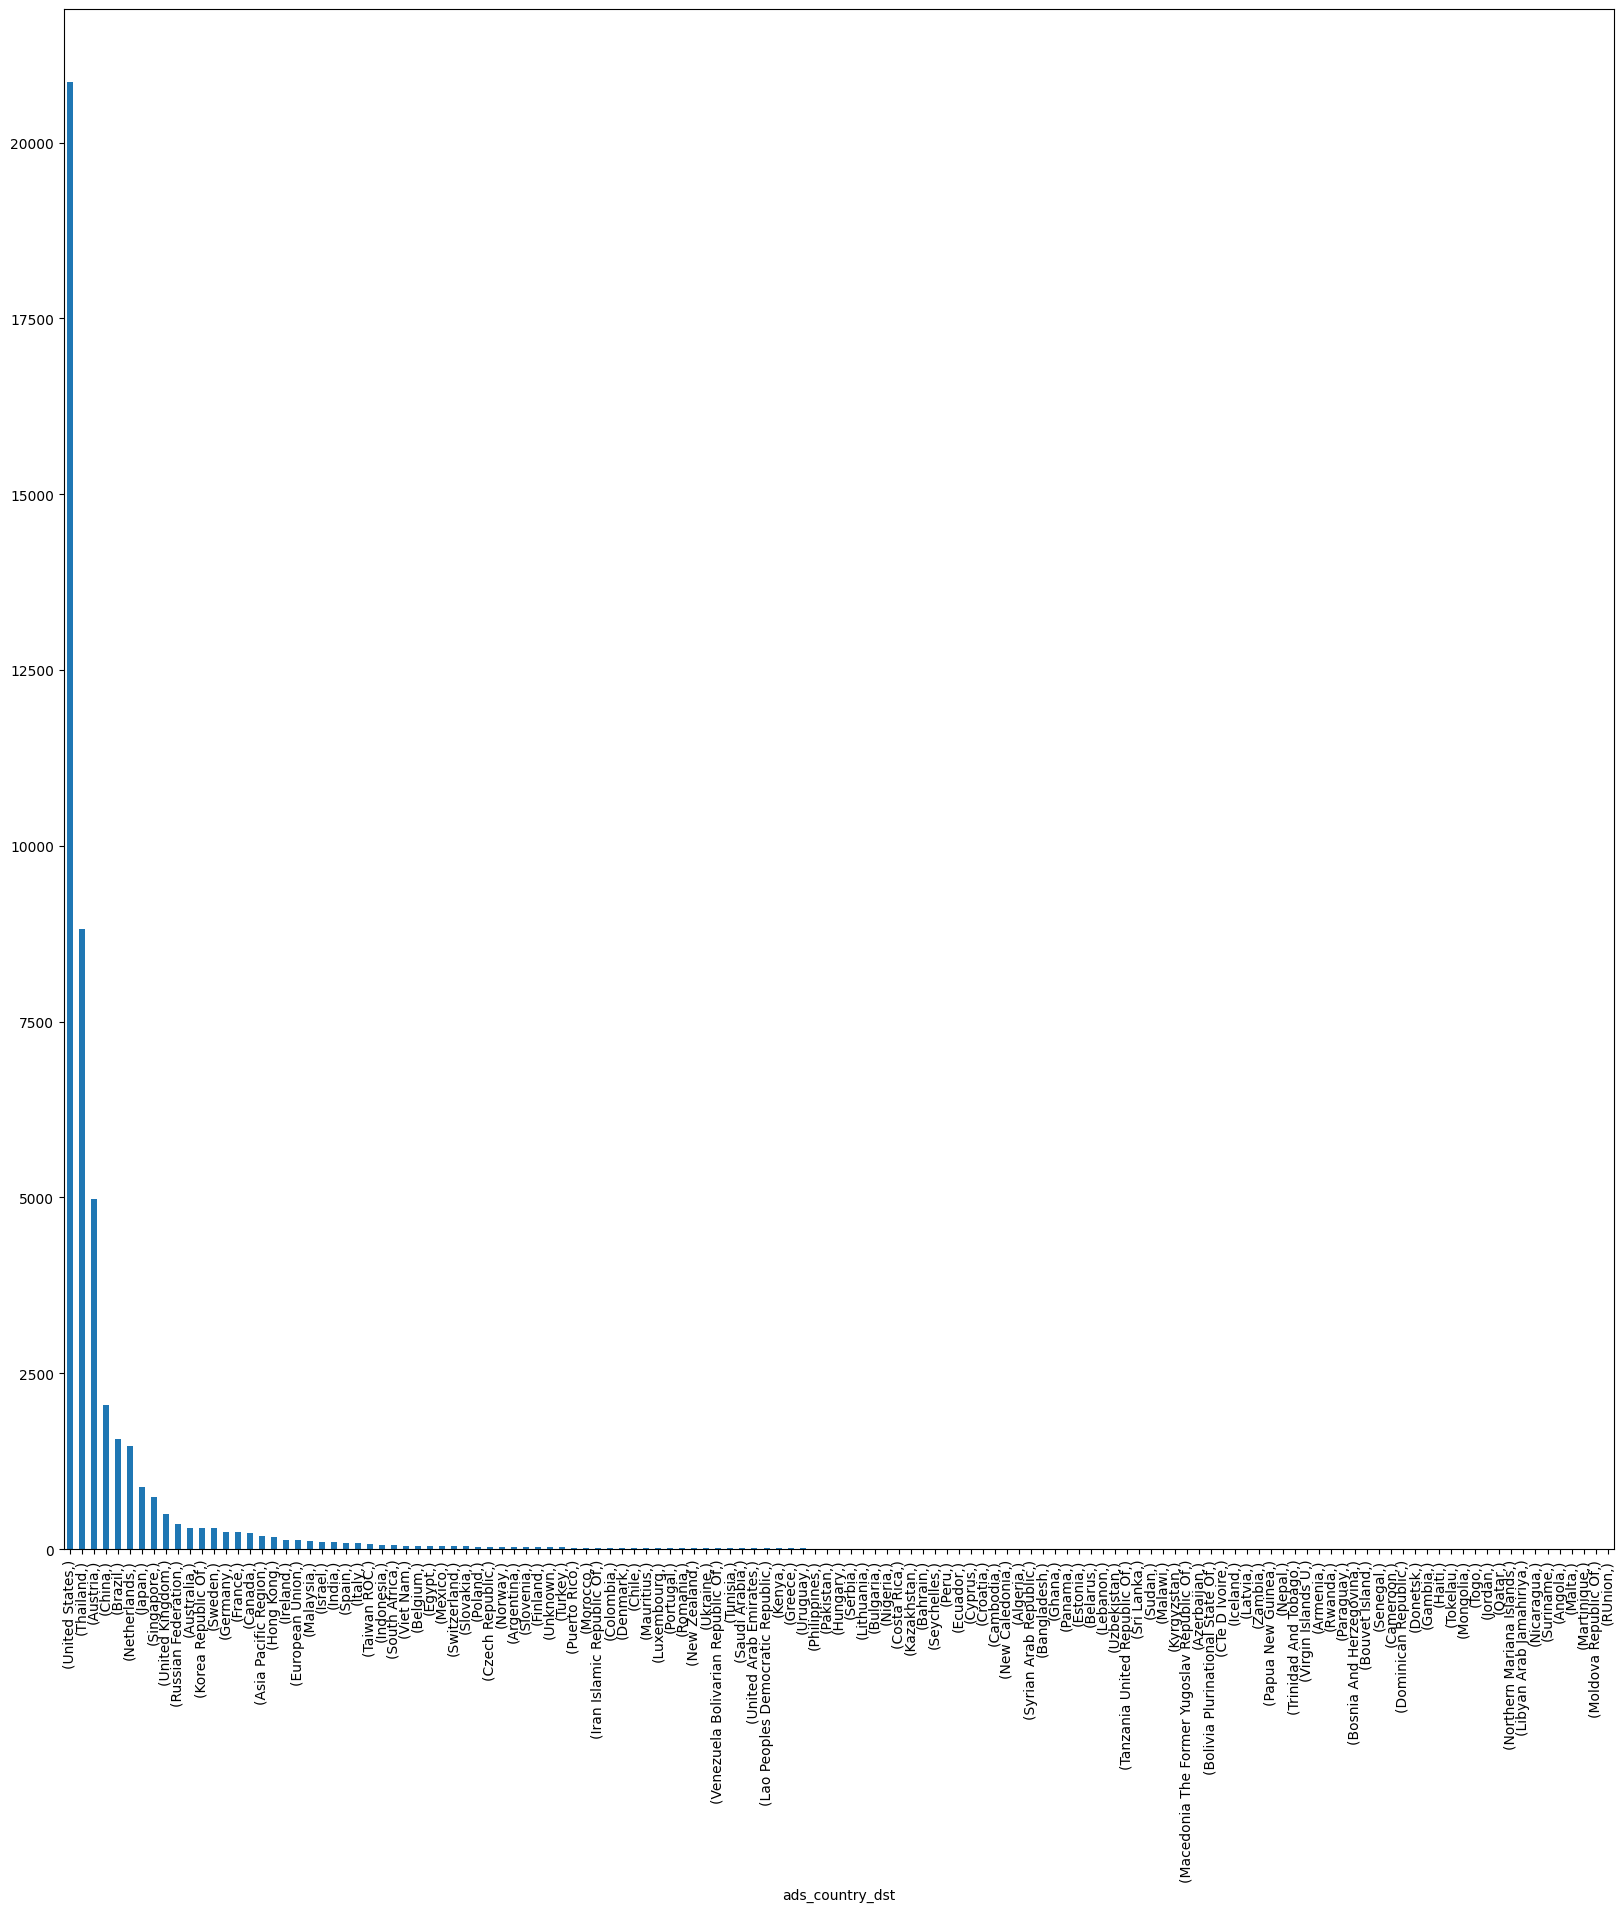

In [ ]:
# Plot the conparison between actual and predicted y
df_categories.value_counts()[: :].plot(kind="bar", figsize=(20,20))
plt.show()